In [2]:
import brainpy as bp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def calculate_d(j, k, N):
    if np.abs(j - k) <= N / 2:
        d = np.abs(j - k)
    elif np.abs(j - k) > N / 2:
        d = N - np.abs(j - k)
    return d


def calculate_L(N, L_ex, L_in, sigma_ex, sigma_in):

    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if i == j:
                L[i, j] = 0
            else:
                d = calculate_d(i, j, N)
                L[i, j] = L_ex * np.exp(
                    -(d ** 2) / (2 * sigma_ex ** 2)
                ) - L_in * np.exp(-(d ** 2) / (2 * sigma_in ** 2))
    return L


def stimuli_input(N, E, sigma, pos):
    e = np.zeros(N)

    for j in range(N):
        d = calculate_d(j, pos, N)
        e[j] = E * np.exp(-(d ** 2) / (2 * sigma ** 2))

    return e


def calculate_W(N, W0, sigma):

    W = np.zeros((N, N))

    for j in range(N):
        for k in range(N):
            d = calculate_d(j, k, N)
            W[j, k] = W0 * np.exp(-(d ** 2) / (2 * sigma ** 2))
    return W

In [4]:
def F(u, s, theta):
    return 1 / (1 + np.exp(-s * (u - theta)))


@bp.odeint(method="euler", dt=0.01)
def cuppini_model(
    Y_a, Y_v, Y_m, t, U_a, U_v, U_m, tau_a=3, tau_v=15, tau_m=1, s=0.3, theta=20
):

    # Auditory
    dY_a = (-Y_a + F(U_a, s, theta)) * (1 / tau_a)

    # Visual
    dY_v = (-Y_v + F(U_v, s, theta)) * (1 / tau_v)

    # Multisensory
    dY_m = (-Y_m + F(U_m, s, theta)) * (1 / tau_m)

    return dY_a, dY_v, dY_m


def run_cuppini(simLength, pos_a, pos_v, N=180, Ea=28, Ev=27, noise=True):

    hist_times = np.arange(0, simLength, 0.01)

    # Synapses
    La = calculate_L(N, L_ex=5, L_in=4, sigma_ex=3, sigma_in=120)
    Lv = calculate_L(N, L_ex=5, L_in=4, sigma_ex=3, sigma_in=120)
    Lm = calculate_L(N, L_ex=3, L_in=2.6, sigma_ex=2, sigma_in=10)
    Wa = calculate_W(N, W0=1.4, sigma=5)
    Wv = calculate_W(N, W0=1.4, sigma=5)
    Wma = calculate_W(N, W0=18, sigma=0.5)
    Wmv = calculate_W(N, W0=18, sigma=0.5)

    # Stim
    ea = stimuli_input(N, E=Ea, sigma=32, pos=pos_a)
    ev = stimuli_input(N, E=Ev, sigma=4, pos=pos_v)
    noise_a = -(Ea * 0.4) + (2 * Ea * 0.4) * np.random.rand(N)
    noise_v = -(Ev * 0.4) + (2 * Ev * 0.4) * np.random.rand(N)

    Y_a, Y_v, Y_m = np.zeros(N), np.zeros(N), np.zeros(N)

    for i in range(hist_times.size):
        t = hist_times[i]

        # Compute cross-modal input
        ca = np.sum(Wa * Y_a, axis=1)
        cv = np.sum(Wv * Y_v, axis=1)

        # Compute external input
        ia = ea + ca
        iv = ev + cv
        im = np.sum(Wma * Y_a, axis=1) + np.sum(Wmv * Y_v, axis=1)

        if noise == True:
            ia += noise_a
            iv += noise_v

        # Compute lateral inpunt
        la = np.sum(La * Y_a, axis=1)
        lv = np.sum(Lv * Y_v, axis=1)
        lm = np.sum(Lm * Y_m, axis=1)

        # Compute unisensory total input
        U_a = la + ia
        U_v = lv + iv

        # Compute multisensory total input
        U_m = lm + im

        # Compute neurons activity
        Y_a, Y_v, Y_m = cuppini_model(Y_a, Y_v, Y_m, t, U_a, U_v, U_m)

    return Y_a, Y_v, Y_m


def plot_areas(Y_a, Y_v, Y_m):

    fig, axs = plt.subplots(2, 2, figsize=(10, 6.6))

    ax1 = plt.subplot(232)
    ax1.plot(Y_m, "r")
    ax1.set_ylim([0, 1])
    ax1.set_xlabel("Posición (grados)", size=12)
    ax1.set_ylabel("Actividad neuronal", size=12)
    ax1.set_title("Multisensorial", size=14)
    ax1.hlines(0.15, 0, 180, linestyles="dashed", colors="k")

    ax2 = plt.subplot(234)
    ax2.plot(Y_a, "b")
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("Posición (grados)", size=12)
    ax2.set_ylabel("Actividad neuronal", size=12)
    ax2.set_title("Auditiva", size=14)

    ax3 = plt.subplot(236)
    ax3.plot(Y_v, "g")
    ax3.set_ylim([0, 1])
    ax3.set_xlabel("Posición (grados)", size=12)
    ax3.set_ylabel("Actividad neuronal", size=12)
    ax3.set_title("Visual", size=14)

    plt.show()


def plot_inference(Y_a, Y_v, Y_m):
    fig, axs = plt.subplots(2, 1, figsize=(5, 7.5))

    ax1 = plt.subplot(211)
    ax1.plot(Y_m, "r", label="Multisensorial")
    ax1.hlines(0.15, 0, 180, linestyles="dashed", colors="k")
    ax1.set_ylim([0, 1])
    ax1.set_xlabel("Posición (grados)", size=12)
    ax1.set_ylabel("Actividad neuronal", size=12)
    ax1.legend()

    ax2 = plt.subplot(212)
    ax2.plot(Y_a, "b", label="Auditiva")
    ax2.plot(Y_v, "g", label="Visual")
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("Posición (grados)", size=12)
    ax2.set_ylabel("Actividad neuronal", size=12)
    ax2.legend()

    fig.subplots_adjust(hspace=0.4)
    plt.show()

### Figure 2

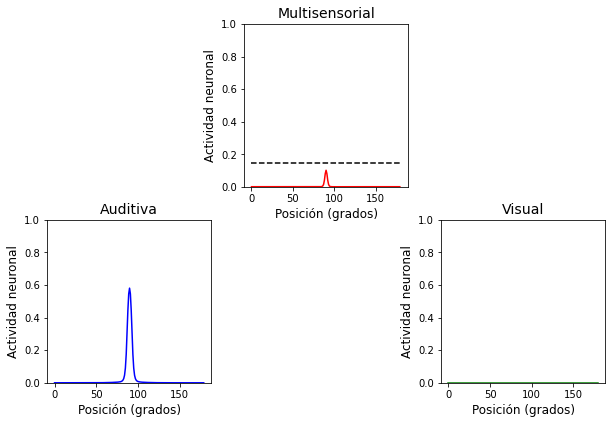

In [5]:
Y_a, Y_v, Y_m = run_cuppini(100, pos_a=90, pos_v=90, Ea=18.75, Ev=0, noise=False)
plot_areas(Y_a, Y_v, Y_m)

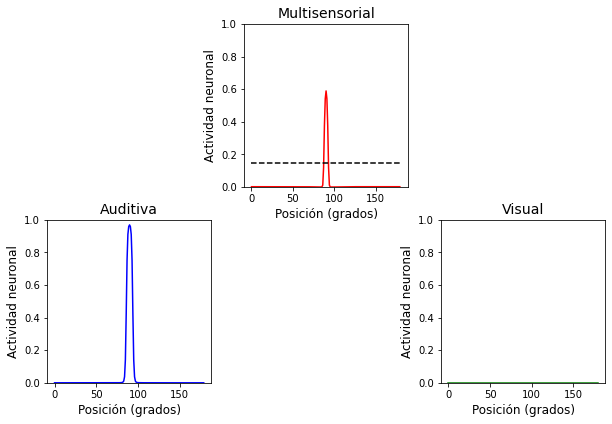

In [6]:
Y_a, Y_v, Y_m = run_cuppini(100, pos_a=90, pos_v=90, Ea=25, Ev=0, noise=False)
plot_areas(Y_a, Y_v, Y_m)

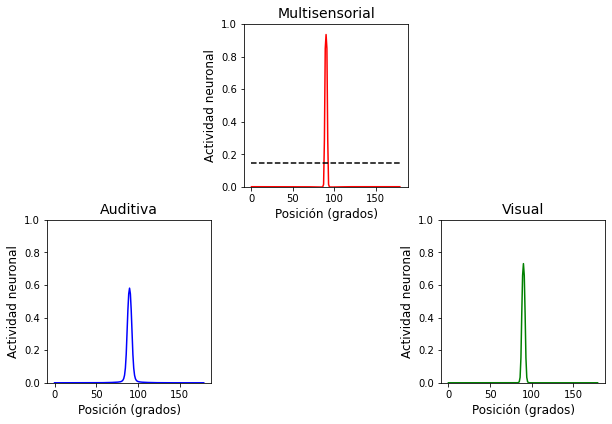

In [7]:
Y_a, Y_v, Y_m = run_cuppini(100, pos_a=90, pos_v=90, Ea=18.75, Ev=18.75, noise=False)
plot_areas(Y_a, Y_v, Y_m)

### Figure 3

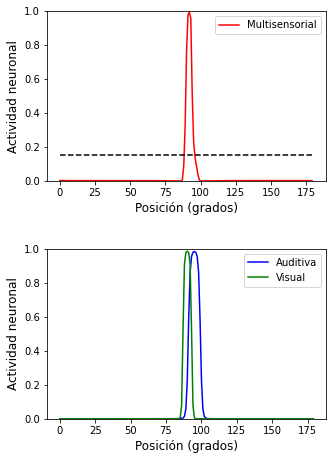

In [8]:
Y_a, Y_v, Y_m = run_cuppini(100, pos_a=95, pos_v=90, noise=False)
plot_inference(Y_a, Y_v, Y_m)

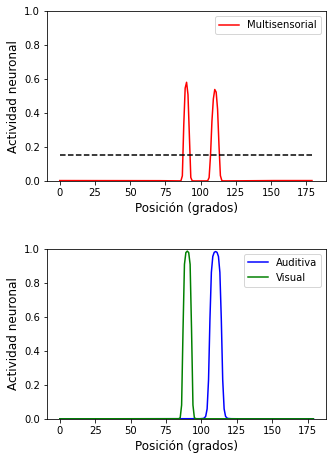

In [9]:
Y_a, Y_v, Y_m = run_cuppini(100, pos_a=110, pos_v=90, noise=False)
plot_inference(Y_a, Y_v, Y_m)

### Figure 4

In [10]:
def myjob(d, sims):
    peak_count = []
    for sim in range(sims):
        Y_a, Y_v, Y_m = run_cuppini(100, pos_a=90 + d, pos_v=90)
        peaks_idx, _ = find_peaks(Y_m, prominence=0.15, height=0.15, distance=2)
        peaks = np.size(peaks_idx)
        peak_count.append(peaks)
    return peak_count.count(1) / sims

In [12]:
from scipy.signal import find_peaks
from joblib import Parallel, delayed

av_distances = np.arange(2, 21, 2)
sims = 10

with Parallel(n_jobs=-1) as parallel:
    res = parallel([delayed(myjob)(i, sims) for i in av_distances])

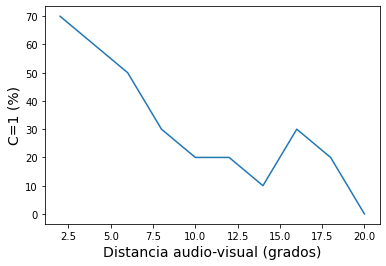

In [13]:
plt.plot(av_distances, np.array(res) * 100)
plt.ylabel("C=1 (%)", size=14)
plt.xlabel("Distancia audio-visual (grados)", size=14)
plt.show()